In [68]:
import xml.etree.ElementTree as ET, time
from copy import copy
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
tree = ET.parse('race1.gpx')
root = tree.getroot()


calculate distance between two gps coordinates

In [6]:
def dist(long1, lat1, elevation1, long2, lat2, elevation2):
    o1, a1, o2, a2 = map(radians, [long1, lat1, long2, lat2])
    
    # difference between longitudes and latitudes
    do = o2-o1
    da = a2-a1
    
    #haversine formula
    a = sin(da/2)**2 + cos(a1) * cos(a2) * sin(do/2)**2
    c = 2*asin(sqrt(a))
    r = 6371 + (elevation1 + elevation2)/2
    return c*r

function to retrieve data from data in the format of the first file

In [14]:
def get_data(root):
    for t in root[1][1]:
        # to make it easier to parse as floats
        vals = (t.get('lon'), t.get('lat'), t[0].text)
        # order is: longitude, latitude, elevation, time, power, atemp, hr, cad
        # todo: parse datetime.
        yield (*map(float, vals), t[1].text, float(t[2][0].text), *map(lambda x : float(x.text), t[2][1]))


function to draw a matrix of scatter plots

In [20]:

def plot_matrix(plot_values, plot_headings):
    c = 0
    for v1, h1 in zip(plot_values, plot_headings):
        for v2, h2 in zip(plot_values, plot_headings):
            plt.figure(1)
            c = c+1
            axes = plt.subplot(len(plot_values), len(plot_values), c)
            axes.set_yticklabels([])
            axes.set_xticklabels([])
            plt.scatter(v1, v2, s=.1)
            if (c-1)%len(plot_values)==0:
                plt.ylabel(h1)
            if (c) > len(plot_values)*(len(plot_values)-1):
                plt.xlabel(h2)
    plt.show()

calculate the values necessary for the analysis

In [38]:
longs, lats, elevs, times, powers, atemps, hrs, cads = map(tuple, zip(*get_data(root)))

# here we convert dists to be in units of 3600 km as every time measurement is 1s, meaning that 
# dists is now speed in km/h
dists = list(map(lambda *a:dist(*a)*3600, longs[1:], lats[1:], elevs[1:], longs[:-1], lats[:-1], elevs[:-1]))

plot_values = (dists, powers, atemps, hrs, cads, longs, lats, elevs)

plot_headings = 'speeds', 'powers', 'atemps', 'hrs', 'cads', 'longs', 'lats', 'elevs'

data_race1 = dict(zip(plot_headings, plot_values))

show the lengths of the values to ensure only speeds is smaller and show how many datapoints we have

In [40]:
print(list(map(len, plot_values)))

[6376, 6377, 6377, 6377, 6377, 6377, 6377, 6377]


calculate the average speed

In [43]:
print(sum(data_race1['speeds'])/len(data_race1['speeds']))

36.985660582641636


plot distributions for entries

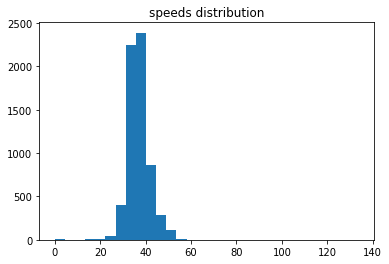

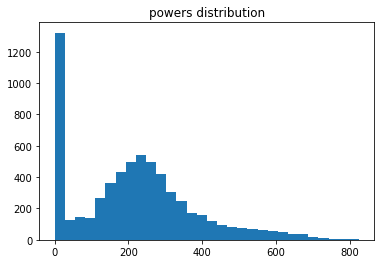

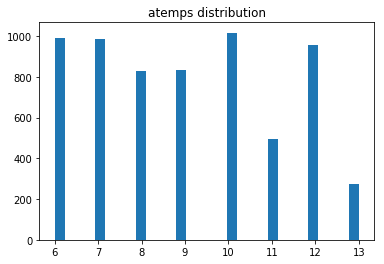

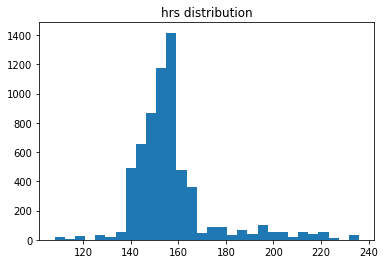

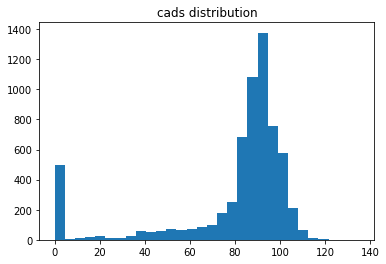

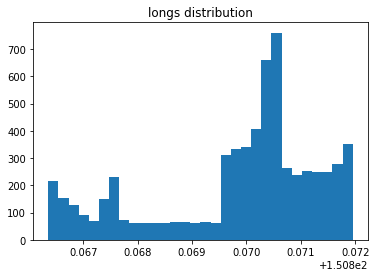

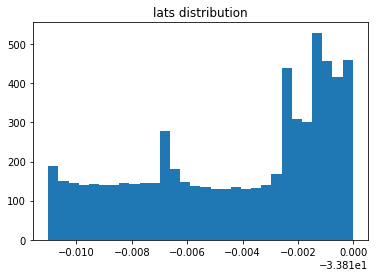

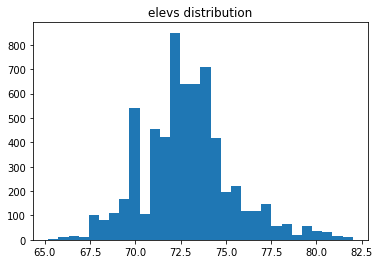

In [52]:
for i, kv in enumerate(data_race1.items()):
    key, value = kv
    i += 1
    plt.figure(i)
    plt.hist(value, bins=30)
    plt.title(key+' distribution')
plt.show()

atemps seems to have a very strange distribution. This is confirmed by the plot matrix:

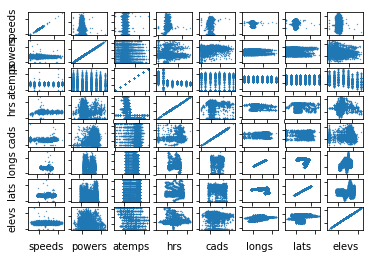

In [64]:
def crop_ll(l):
    """crops a list of lists so that they are all the length of the smallest list.
    care must be used when using this function as it could mean corresponding datapoints are offset.
    this is a big deal if your data is not continuous (such as survey results)"""
    length = len(min(l, key=len))
    return tuple(map(lambda x:x[:length], l))

plot_matrix(crop_ll(data_race1.values()), data_race1.keys())

this plot is not very useful as the individual plots are so small, so we will only plot speeds, powers and hrs

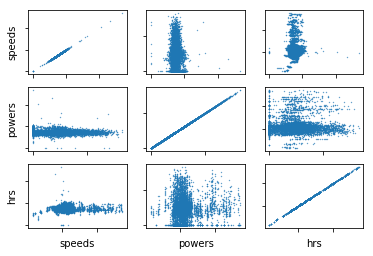

In [79]:
data_race1_b = {'speeds':data_race1['speeds'], 'powers':data_race1['powers'], 'hrs':data_race1['hrs']}
plot_matrix(crop_ll(data_race1_b.values()), data_race1_b.keys())

there doesnt seem to be any type of correlation between any of these variables - lets try removing some outliers!

In [ ]:
def remove_outliers(data:dict, key):
    